In [86]:
import torch
from torch_geometric.data import Data
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
from tqdm.auto import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

import os.path as osp

import torch
from torch_geometric.data import Dataset, download_url, InMemoryDataset
from torch_geometric.io import fs

<h1>Explore the LUCAS0 dataset</h1>

Here is the structure of the LUCAS0 dataset:

<img src="images/lucas0_structure.png" alt="Structure of the LUCAS0 dataset." width=600 height=400>

Here are how the features are connected:
* [Anxiety, Smoking] -> [2, 0]
* [Peer Pressure, Smoking] -> [3, 0]
* [Smoking, Yellow Fingers] -> [0, 1]
* [Smoking, Lung Cancer] -> [0, 11]
* [Genetics, Lung Cancer] -> [4, 11]
* [Genetics, Attention Disorder] -> [4, 5]
* [Attention Disorder, Car Accident] -> [5, 7]
* [Lung Cancer, Coughing] -> [11, 10]
* [Lung Cancer, Fatigue] -> [11, 8]
* [Allergy, Coughing] -> [9, 10]
* [Coughing, Fatigue] -> [10, 8]
* [Fatigue, Car Accident] -> [8, 7]

The from nodes are the first element, given by
* [2, 3, 0, 0, 4, 4, 5, 11, 11, 9, 10, 8],

and the to nodes are the second element, given by
* [0, 0, 1, 11, 11, 5, 7, 10, 8, 10, 8, 7].

In [4]:
# Load the dataset
df = pd.read_csv('data/lucas0_train.csv')
df

,Smoking,Yellow_Fingers,Anxiety,Peer_Pressure,Genetics,Attention_Disorder,Born_an_Even_Day,Car_Accident,Fatigue,Allergy,Coughing,Lung_cancer
0,0,0,1,0,0,1,0,1,0,1,0,0
1,0,1,0,0,0,0,1,0,1,0,1,1
2,1,1,1,0,1,1,1,1,1,1,1,1
3,0,0,0,1,0,0,1,0,0,0,0,0
4,1,1,1,0,0,1,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,1,0,0,0,0,1,1,0,1,1
1996,1,1,1,0,0,0,0,0,1,0,1,1
1997,1,1,0,1,0,0,1,0,1,0,0,1
1998,1,1,1,0,1,1,0,1,1,0,1,1


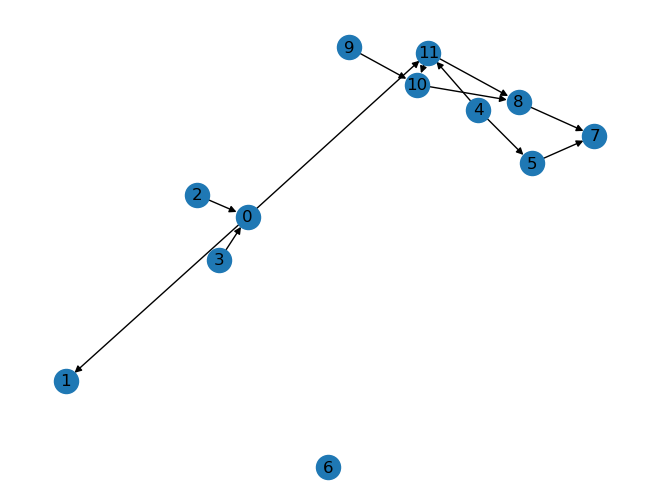

In [97]:
class LUCAS0Dataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(LUCAS0Dataset, self).__init__(root, transform, pre_transform)
        self.data = fs.torch_load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return ['lucas0_train.csv']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        # Download to `self.raw_dir`.
        download_url('https://www.causality.inf.ethz.ch/data/lucas0_train.csv', self.raw_dir)

    def process(self):
        print(self.processed_paths)
        # Load in the data
        self.data = pd.read_csv(self.raw_paths[0])
        
        # Get the node features
        self._get_node_features()
        
        # Get the edge index
        self._get_edge_index()
    
        # Get the labels
        self._get_labels()
        
        # Save the data
        data = Data(x=self.X, edge_index=self.edge_index, y=self.y)
        
        # Save the data
        torch.save(data, osp.join(self.processed_dir, 'data.pt'))
        
        
    def _get_node_features(self):
        self.X = torch.tensor(self.data.values, dtype=torch.float).t()
        
    
    def _get_edge_index(self):
        from_list = [2, 3, 0, 0 , 4 , 4, 5, 11, 11, 9 , 10, 8]
        to_list   = [0, 0, 1, 11, 11, 5, 7, 10, 8 , 10, 8 , 7]
        self.edges = [(i, j) for i, j in zip(from_list, to_list)]  # Connect all nodes
        self.edge_index = torch.tensor(self.edges, dtype=torch.long).t().contiguous()
    
    
    def _get_labels(self):
        self.y = torch.tensor(self.data.Lung_cancer.values, dtype=torch.float)        


    def len(self):
        return len(self.processed_file_names)

dataset = LUCAS0Dataset(root='data/')[0]

# Visualize the graph
G = to_networkx(dataset)
nx.draw(G, with_labels=True)
plt.show()

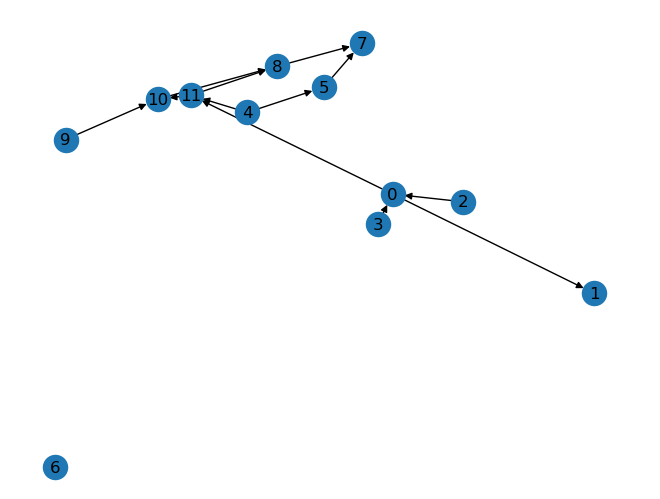

In [48]:
# Your tabular data
tabular_data = df.values

from_list = [2, 3, 0, 0, 4, 4, 5, 11, 11, 9, 10, 8]
to_list   = [0, 0, 1, 11, 11, 5, 7, 10, 8, 10, 8, 7]

# Create graph data
edges = [(i, j) for i, j in zip(from_list, to_list)]  # Connect all nodes
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Node features
x = torch.tensor(tabular_data, dtype=torch.float).t()

# Assuming there are no node labels or edge features in this example
data = Data(x=x, edge_index=edge_index, y=df.Lung_cancer.values)

# Plot the data using networkx
G = to_networkx(data)
nx.draw(G, with_labels=True)

In [56]:
a = KarateClub()
a.x.shape

torch.Size([34, 34])